# Case Study 1:
## Quora Question Pair Similarity


## What is Quora?
Quora is a place to gain and share knowledge. It's a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

### 1. Problem: Given Two Questions Q1 and Q2. We have to determine if these two questions are duplicate of each other or not.

Quora needs to identify if both Questions are similiar and connect both of them so that both the answers may also get connected thereby improoving customer experience on Quora. Also answer to one question will also be the answer to other similiar question so readers will get to read various answers. 
EXAMPLE:
Q1: Where can I get cheap food in Kanpur?
Q2 Where are the cheap food sold in Kanpur?
Q3 How can I get cheap food in kanpur?

All the questions have same meaning but they are worded differntly. So our goal is to find duplicate questions and merge their answers so that we can get better results.


1. Identify which questions asked on Quora are duplicates of questions that have already been asked.
2. This could be useful to instantly provide answers to questions that have already been answered.
3. We are tasked with predicting whether a pair of questions are duplicates or not.

## 1.1 Useful Links:
Dataset is taken from https://www.kaggle.com/c/quora-question-pairs

## 1.2Business Objectives and Constraints:

1. The cost of Misclassification is very high. Suppose we predict two questions to be similiar which are actually not similiar i.e. they are having slight difference. Thus answers of Q1 will be shown while searching Q2.
2. So we have to find Probability of similiarity of questions Q1 and Q2. 
3. No strict latency constraints. Here we do not want very fast output as we are more focused on correct output.
4. Interpretability is partially important. As while designing we need to know why questions Q1 and Q2 are similiar, but we are not needed to tell this to customers.

## 2. Mapping to a ML Problem:

### 2.1 Data Overview:
1. Data is in file Train.csv
2. Train.csv contains 5 cols: qid1, qid2, question_1, question_2, is_duplicate.
3. Size of Train.csv: 60 Mb
4. Number of rows: 404,290

This is a binary classification problem.

### 2.2 Performance Metric:
1. log-loss: primary metric
2. Binary confusion metric

### 2.3 Train and Test Split:

We are randomly splitting Train and Test in the ratio of 80:20.

## 3 Exploratory Data Analysis:  

In [1]:
# 1. Importing Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected= True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

from os import path

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup


from wordcloud import WordCloud, STOPWORDS

### 3.1 Reading Data

In [2]:
# Reading data
data= pd.read_csv('train.csv')

In [3]:
print(data.shape)

(404290, 6)


Number of Datapoints in train data= 404290

In [4]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


### Observation:
Here we observe that for all data columns:

1 row of question1 and 2 rows of question2 have Null values


1. id: row id
2. qid1: unique id for question 1
3. qid2: unique id for question 2
4. question1 and question 2: text data containing questions
5. is_duplicate: This is the class label which we have to predict. If two questions are similiar then is_duplicate== 1 else 0.

### 3.2 Handling Missing Values:

In [6]:
# Handling Missing Values will not effect our dataset as we are having 404290 datapoints and we are removing 3 null datapoints.
data= data.dropna()
print("We have "+str(data.shape[0])+" Data points in our dataset.")
print("We have "+str(data.shape[1])+" Features in out dataset.")

We have 404287 Data points in our dataset.
We have 6 Features in out dataset.


### 3.3 Visualizing and Exploring Dataset

#### 3.3.1 Distribution of Data points among Output classes

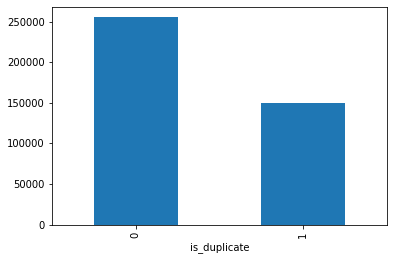

In [7]:
# Distribution of Data points among output classes:
data.groupby('is_duplicate')['id'].count().plot.bar()

1. Here we can observe that around 250000 questions pairs are not similiar and around 150000 question pairs are similiar.
2. This dataset is not Balenced as one class is dominating.


In [8]:
print("total number of questions:-", len(data))

total number of questions:- 404287


In [9]:
print("Not Similiar Questions:-", 100-round(data['is_duplicate'].mean()*100,2))
print("Similiar Questions:-", round(data['is_duplicate'].mean()*100,2))

Not Similiar Questions:- 63.08
Similiar Questions:- 36.92


This shows that in nearly 63% of the given data thw question pairs are not similiar and in 37% of the data we same similiar question pairs.

#### 3.3.2 Number of Unique Questions:

In [10]:
# Number of Unique Questions:
qids= pd.Series(data['qid1'].tolist()+ data['qid2'].tolist())
unique_qs= len(np.unique(qids))
q_more_than_one_time= np.sum(qids.value_counts()>1)
print("Total number of unique questions that appear more than one time {} ({}%)\n".format(q_more_than_one_time,q_more_than_one_time/unique_qs*100))
print("Max number of times a single question is repeated:- {}\n".format(max(qids.value_counts())))
qvals= qids.value_counts()
qvals= qvals.values

Total number of unique questions that appear more than one time 111778 (20.779322178205675%)

Max number of times a single question is repeated:- 157



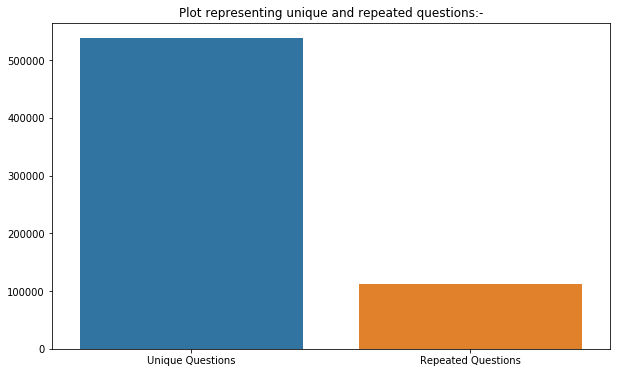

In [11]:
x= ['Unique Questions','Repeated Questions']
y= [unique_qs, q_more_than_one_time]
plt.figure(figsize=(10,6))
plt.title("Plot representing unique and repeated questions:-")
sns.barplot(x,y)
plt.show()

#### 3.3.2 Checking for Duplicates:

In [12]:
# Checking whether there are any repeated pair of questions
pair_dup= data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("Number of duplicate question pairs:", (pair_dup).shape[0]- data.shape[0])


Number of duplicate question pairs: 0


There are no duplicate question pairs in the given dataset.

### 3.5 Number of occurrences of each questions:

Maximum number of times  single question is repeated: 157



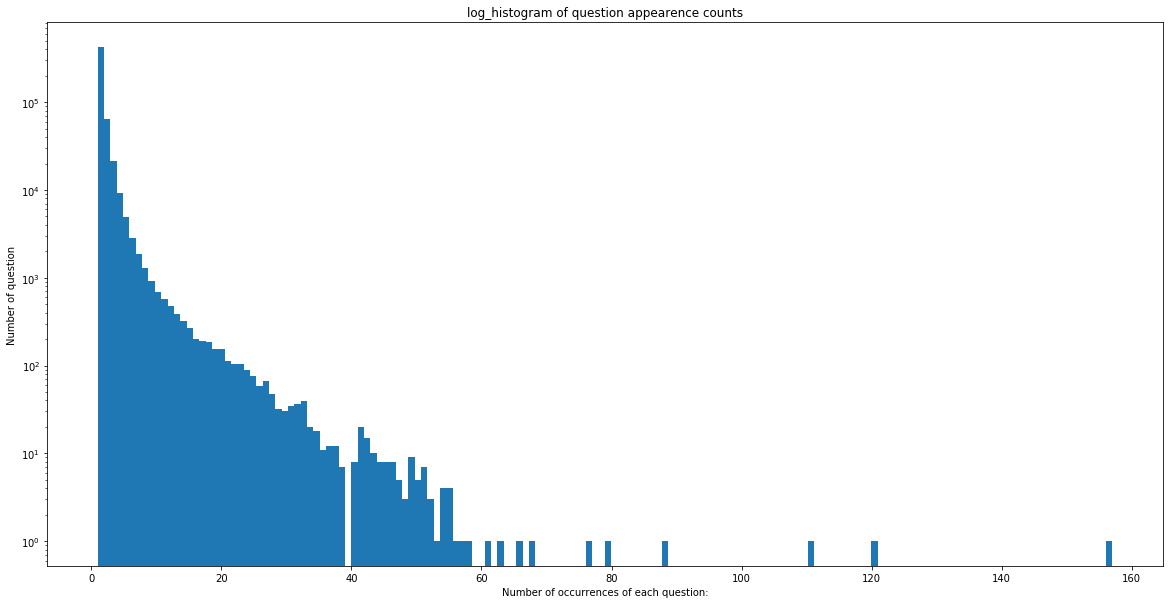

In [13]:
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(),bins= 160)
plt.yscale('log',nonposy= 'clip')
plt.title("log_histogram of question appearence counts")
plt.xlabel('Number of occurrences of each question:')

plt.ylabel('Number of question')
print('Maximum number of times  single question is repeated: {}\n'.format(max(qids.value_counts())))
plt.show()



### Observation:
1. One Question has occurred 157 times.
2. Maximum questions occurred only once in the dataset.
3. Few Questions occurred more than 60 times.

# Feature Engineering

### Creating Artificial Features:

In [14]:
# Basic Feature Extraction
if os.path.isfile('df_fe_wihtout_preprocessing_train.csv'):
    data= pd.read_csv('df_fe_without_preprocessing_train.csv',encoding= 'latin-1')
else:
    # freq_qid1= frequency of qid1
    data['freq_qid1']=data.groupby('qid1')['qid1'].transform('count')
    
    # freq_qid2= frequency of qid2
    data['freq_qid2']= data.groupby('qid2')['qid2'].transform('count')
    
    #length of q1
    data['q1_len']= data['question1'].str.len()
    
    # Length of q2
    data['q2_len']=data['question2'].str.len()
    
    # Number of words in question 1
    data['q1_n_words']= data['question1'].apply(lambda x: len(x.split(" ")))
    
    # Number of words in question 1    
    data['q2_n_words']= data['question2'].apply(lambda x: len(x.split(" ")))
    
    # Word Common= number of words that are common in question 1 and question 2
    def normalized_word_common(row):
        w1= set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2= set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0* len(w1 & w2)
    data['word_common']= data.apply(normalized_word_common, axis= 1)
    
    #word_total= total number of words in question 1 + total number of words in question 2
    def  normalized_word_total(row):
        w1= set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2= set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0* (len(w1)+ len(w2))
    data['word_total']= data.apply(normalized_word_total,axis= 1)
    
    #word_share= word_common/ word_total
    def normalized_word_share(row):
        w1= set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2= set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0* len(w1 & w2)/ (len(w1)+ len(w2))
    data['word_share']= data.apply(normalized_word_share, axis= 1)
    
    # freq_q1+q2= total frequency of q1 and q2
    data['freq_q1+q2']=data['freq_qid1']+ data['freq_qid2']
    
    #absolute diffrence of frequency of q1 and q2
    data['freq_q1-q2']= abs(data['freq_qid1']- data['freq_qid2'])
    
    data.to_csv('df_fe_without_preprocessing_train.csv',index= False)
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1_len,q2_len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


## Visualization of Artificial Features:

### Visualization of word share Feature

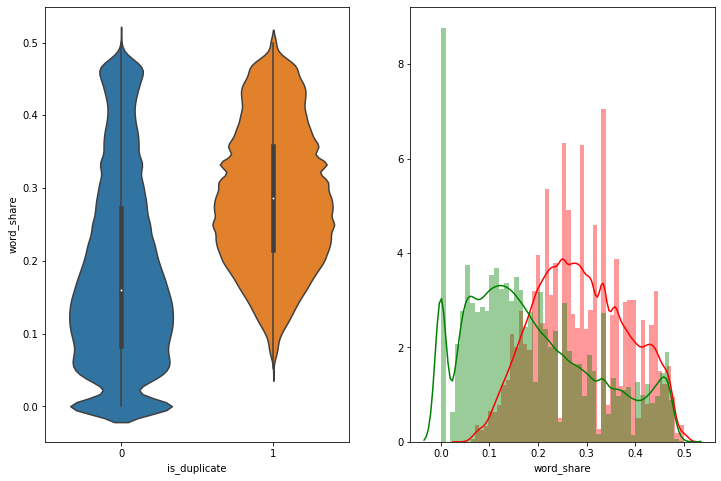

In [15]:
# For Word Share Features:
plt.figure(figsize= (12,8))
plt.subplot(1,2,1)
sns.violinplot(x= 'is_duplicate',y= 'word_share',data= data[0:])
plt.subplot(1,2,2)

sns.distplot(data[data['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')

sns.distplot(data[data['is_duplicate'] == 0.0]['word_share'][0:] , label = "0", color = 'green')
plt.show()


### Observation:
1. In Violin Plot , word share of duplicate questions is greater than that of non-duplicate questions.
2. The distribution of word share is overlapping more in right side. Hence that portion contains questions that have high word share.

### Visualization of word_common Feature:


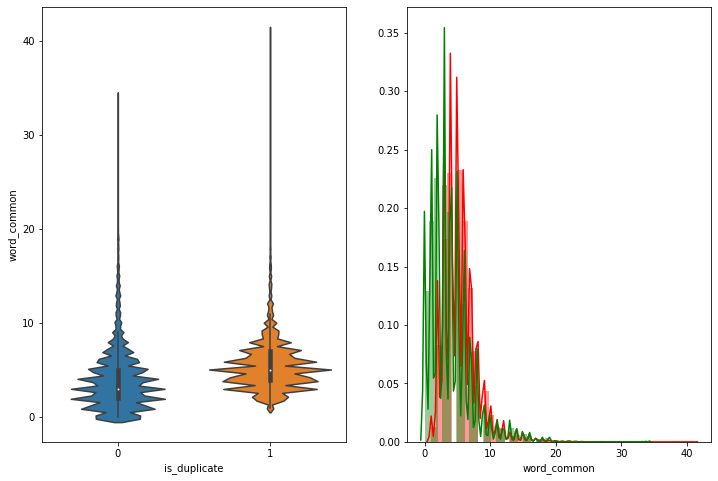

In [16]:
plt.figure(figsize= (12,8))
plt.subplot(1,2,1)
sns.violinplot(x= 'is_duplicate',y= 'word_common',data= data[0:])
plt.subplot(1,2,2)

sns.distplot(data[data['is_duplicate'] == 1.0]['word_common'][0:] , label = "1", color = 'red')

sns.distplot(data[data['is_duplicate'] == 0.0]['word_common'][0:] , label = "0", color = 'green')
plt.show()


### Observation:
1. Word common is more in case of duplicate questions.
2. Distribution of duplicate and non duplicate questions is highly overlapping.

## Preprocessing of text:




Preprocessing:
1. Removing HTML Tags
2. Removing Punctuations
3. Performing Stemming
4. Removing stopwords
5. Expanding Contractions etc.

In [17]:
safe_div= 0.0001
stop_words= set(stopwords.words('english'))
print(stop_words)

{'should', 'your', 'herself', 'here', 'when', 'who', 'having', 'before', 'between', 'aren', 'don', 'yourself', "don't", 'does', 'the', 'above', 's', 'very', 'y', 'll', "it's", 'we', "doesn't", "couldn't", 'this', 'then', 'most', 'was', 'wasn', "haven't", 'they', 'no', 'by', 'have', 'from', 'over', 'so', 'in', 'or', 'with', 'not', 'them', 'other', 'she', 'd', 'wouldn', 'o', "should've", 'both', "weren't", 'for', 'm', 'ours', 'won', "shouldn't", 'now', 've', "mightn't", 'hers', 'it', 'his', 'haven', 'her', 'can', 'isn', 'whom', 'more', 'had', 'just', "aren't", "wasn't", 'why', 'hadn', "hasn't", 'against', "that'll", 'than', "won't", 'that', 'an', 'mightn', 'there', 'those', 'mustn', 'be', 'a', 'weren', 'didn', 'again', 'out', 'is', 'been', 'until', 'each', 'which', 'because', 'of', 'being', 'hasn', 'if', 'below', 'their', 'down', 'themselves', 'once', 'at', "she's", 'ourselves', 'further', 'my', 'itself', 'too', 'am', "shan't", 'off', 'needn', 'himself', 'theirs', 'doesn', 'during', 'you

In [18]:
# Function to compute and get features
def preprocess(x):
    x= str.lower()
    x= x.replace(",000,000","m").replace(",000","k").replace("′","'").replace("’","'")\
    .replace("won't","will not").replace("cannot","can not").replace("can't","can not")\
    .replace("n't","not").replace("what's","what is").replace("it's","it is")\
    .replace("'ve","have").replace("i'm","i am").replace("'re","are").replace("he's","he is")\
    .replace("she's","she is").replace("'s","own").replace("%","percent").replace("₹","rupee")\
    .replace("$","dollar").replace("€","euro").replace("'ll","will")
    x= re.sub(r"([0-9]+)000000", r"\1m",x)
    x= re.sub(r"([0-9]+)000",r"\1k",x)
    
    porter= PorterStemmer()
    pattern= re.compile('\W')
    
    if type(x)== type(''):
        x= re.sub(pattern,' ',x)
        
    if type(x)== type(''):
        x= porter.stem(x)
        example1= BeautifulSoup(x)
        x= example1.get_text()
    return x


## Advanced Feature Extraction: NLP and Fuzzy Features

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features: 
- **cwc_min**: Ratio of common_word_count to min lenghth of word count of Q1 and Q2
       cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
- **cwc_max**:Ratio of common_word_count to max lenghth of word count of Q1 and Q2
        cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
- **csc_min**: Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
        csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
- **csc_max**:Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
        csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))

- **ctc_min**:Ratio of common_token_count to min lenghth of token count of Q1 and Q2
        ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))


- **ctc_max**: Ratio of common_token_count to max lenghth of token count of Q1 and Q2
        ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
- **last_word_eq**: Check if First word of both questions is equal or not
        last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
- **first_word_eq**: Check if First word of both questions is equal or not
        first_word_eq = int(q1_tokens[0] == q2_tokens[0])
- **abs_len_diff**: Abs. length difference
        abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
- **mean_len**:Average Token Length of both Questions
        mean_len = (len(q1_tokens) + len(q2_tokens))/2
- fuzz ratio
- fuzz partial ratio
- token_set_ratio
- token_sort_ratio
- longest_substr_ratio

In [19]:
def get_features(x):
    token_features= [0.0]*10
    
    #converting sentence into tokens:
    q1_tokens= q1.split()
    q2_tokens= q2.split()
    
    if len(q1_tokens)== 0 or len(q2_tokens)==0:
        return token_features
    
    #Get the non-stopwords in both questions:
    q1words= set([word for word in q1_tokens if word not in stop_words])
    q2words= set([word for word in q2_tokens if word not in stop_words])
    
    #Get the stopwordsi n both questions:
    q1stopwords= set([word for word in q1_tokens if word in stop_words])
    q2stopwords= set([word for word in q2_tokens if word in stop_words])
    
    #Get the common non-stopwords in both questions:
    common_words= len(q1words.intersection(q2words))
    #Get the common stopwords in both questions:
    common_stop= len(q1stopwords.intersection(q1stopwords))
    
    #Get the common question tokens from both questions:
    common_token= len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0]= common_words/ min(len(q1words), len(q2words)) + safe_div
    token_features[1]= common_words/ max(len(q1words), len(q2words)) + safe_div
    token_features[2]= common_stop/ min(len(q1stopwords), len(q2stopwords)) + safe_div
    token_features[3]= common_stop/ max(len(q1stopwords), len(q2stopwords)) + safe_div
    token_features[4]= common_token/ min(len(q1_token), len(q2_token)) + safe_div
    token_features[5]= common_token/ max(len(q1_token), len(q2_token)) + safe_div
    
    #Last word of both question is same or not:
    token_features[6]= int(q1_token[-1]== q2_token[-1])
    
    #First word of both question is same or not:
    token_features[7]= int(q1_token[0]== q2_token[0])
    
    token_features[8]= abs(len(q1_token)- len(q2_token))/2
    
    #Average Token length of both questions:
    token_features[9]= (len(q1_token)+ len(q2_token))/2
    return token_features

#get the longest common substring
def get_longest_substr(a,b):
    strs= list(distance.lcssubstrings(a,b))
    if len(strs)== 0:
        return 0
    else:
        return len(strs[0])/min(len(a), len(b))+1
    
def extract_features(data):
    #preprocessing each question:
    data['question1']= data['question1'].fillna("").apply(preprocess)
    data['question2']= data['question2'].fillna("").apply(preprocess)
    
    print("token Features:- ")
    
    # Merging features with dataset:
    token_features= data.apply(lambda x: get_token_features(x['question1'],x['question2']),axis= 1)
    data['cwc_min']= list(map(lambda x: x[0], token_features))
    data['cwc_max']= list(map(lambda x: x[1], token_features))
    data['csc_min']= list(map(lambda x: x[2], token_features))
    data['csc_max']= list(map(lambda x: x[3], token_features))
    data['ctc_min']= list(map(lambda x: x[4], token_features))
    data['ctc_max']= list(map(lambda x: x[5], token_features))
    data['last_word_eq']= list(map(lambda x: x[6], token_features))
    data['first_word_eq']= list(map(lambda x: x[7], token_features))
    data['abs_len_diff']= list(map(lambda x: x[8], token_features))
    data['mean_len']= list(map(lambda x: x[9], token_features))
    
    #Computing fuzzy features:
    print('Fuzzy Features:-')
    data['token_set_ratio']= data.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis= 1)
    data['token_sort_ratio']= data.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis= 1)
    data['fuzz_ratio']= data.apply(lambda x: fuzz.QRatio(x['question1'], x['question2']), axis= 1)
    data['fuzz_partial_ratio']= data.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis= 1)
    data['longest_substr_ratio']= data.apply(lambda x: fuzz.longest_substr_ratio(x['question1'], x['question2']), axis= 1)
    return df

In [20]:
if os.path.isfile("nlp_features_train.csv"):
    data= pd.read_csv('nlp_features_train.csv',encoding= 'latin-1')
    data.fillna('')
else:
    print("Extracting features for train:")
    data= pd.read_csv("train.csv")
    data= extract_features(data)
    data.to_csv("nlp_features_train.csv",index= False)
data.head(2)


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


### Analysis of Extracted Features:

#### Plotting Word Cloud

- Creating a word cloud of duplicates and non-duplicates question pairs
- By doing this we can observe most frequent occuring words

In [21]:
d_duplicate= data[data['is_duplicate']==1]
d_nonduplicate= data[data['is_duplicate']==0]

#Converting 2d array of q1 and q2 and flatten the array :
p= np.dstack([d_duplicate['question1'], d_duplicate['question2']]).flatten()
n= np.dstack([d_nonduplicate['question1'], d_nonduplicate['question2']]).flatten()

print("Nunber of data points in class 1:", len(p))
print("Number of data points in class 0:", len(n))

#saving np array into text file:
#np.savetxt('train_p.txt', p, delimiter= ' ', fmt= '%s')
#np.savetxt('train_n.txt', n, delimiter= ' ', fmt= '%s')


Nunber of data points in class 1: 298526
Number of data points in class 0: 510054


In [24]:
#Reading text files and removing stopwords:
d= path.dirname('.')
textp_w= open(path.join(d, 'train_p.txt')).read()
textn_w= open(path.join(d, 'train_n.txt')).read()
stopwords= set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
print("Total number of words in duplicate pair questions:", len(textp_w))
print("total number of words in non duplicate pair questions:",len(textn_w))

Total number of words in duplicate pair questions: 16109886
total number of words in non duplicate pair questions: 3335825


Word Cloud for Duplicate Question pairs


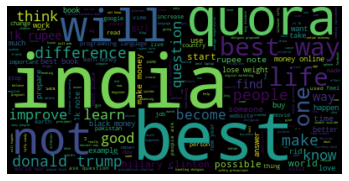

In [25]:
# Generate word cloud for duplicate question pairs:
wc= WordCloud(max_words= len(textp_w), stopwords= stopwords)
wc.generate(textp_w)
print("Word Cloud for Duplicate Question pairs")
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

**Observation:-**
- Words like india, beast, quora, not, will occurs more frequently in duplicate question pairs.

Word Cloud for non-Duplicate Question pairs


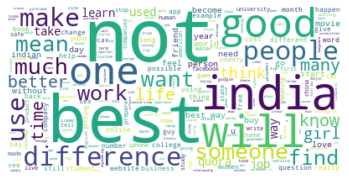

In [26]:
#Generating word cloud for non duplicate question pairs:
wc= WordCloud(background_color ="white", max_words= len(textn_w), stopwords= stopwords)
wc.generate(textn_w)
print("Word Cloud for non-Duplicate Question pairs")
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

**Observation:-**
- Words like best, not, india, will, good, people, one occurs more frequently in non-duplicate question pairs.

#### Pair Plot of features:['ctc_min','cwc_min','csc_min','token_sort_ratio']

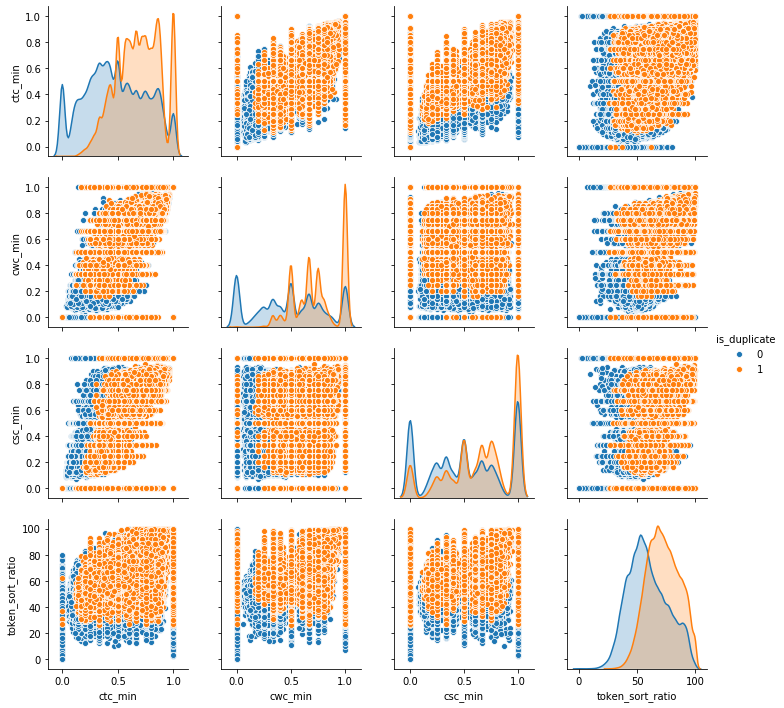

In [27]:
n= data.shape[0]
sns.pairplot(data[['ctc_min','cwc_min','csc_min','token_sort_ratio','is_duplicate']][0:n],hue= 'is_duplicate',vars=['ctc_min','cwc_min','csc_min','token_sort_ratio'])
plt.show()

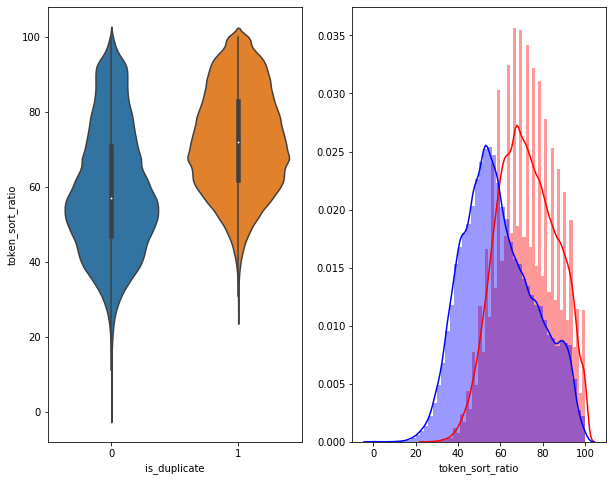

In [28]:
### Distribution of token_sort_ratio:
plt.figure(figsize= (10,8))
plt.subplot(1,2,1)
sns.violinplot(x= 'is_duplicate',y= 'token_sort_ratio',data= data[0:],)
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate']==1.0]['token_sort_ratio'][0:], label= "1", color= 'red')
sns.distplot(data[data['is_duplicate']==0.0]['token_sort_ratio'][0:], label= "0", color= 'blue')
plt.show()

**Observation:-**
- ctc_min (common_token_count) vc ctc_min are highly overlapping
- last_word equal if normally distributed for duplicate questions.
- we can't find any features which can easily classfy both the classes.
- advanced methods like word2vec or glove can be used to classify it.


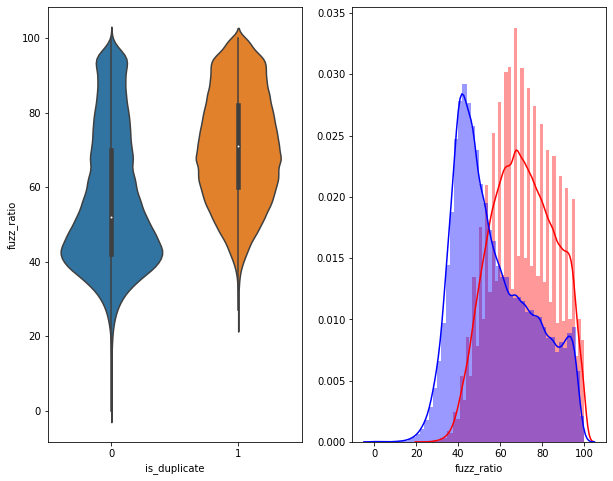

In [29]:
#Distribution of fuzz ratio:
plt.figure(figsize= (10,8))
plt.subplot(1,2,1)
sns.violinplot(x= 'is_duplicate',y= 'fuzz_ratio',data= data[0:],)
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate']==1.0]['fuzz_ratio'][0:], label= "1", color= 'red')
sns.distplot(data[data['is_duplicate']==0.0]['fuzz_ratio'][0:], label= "0", color= 'blue')
plt.show()

**Observation:-**

## Visualization:

In [30]:
#Using TSNE for Dimensionality reduction for 15 features
from sklearn.preprocessing import MinMaxScaler
data_sampled= data[0:50000]
x= MinMaxScaler().fit_transform(data_sampled[['cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq', 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y= data_sampled['is_duplicate'].values

In [31]:
tsne2d= TSNE(n_components= 2, init= 'random',random_state=101, method='barnes_hut',n_iter= 1000, verbose= 2, angle= 0.5).fit_transform(x)

<IPython.core.display.Javascript object>

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 2.650s...
[t-SNE] Computed neighbors for 50000 samples in 29.131s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

In [ ]:
data= pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1], 'label':y})
sns.lmplot(data= data, x= 'x', y= 'y', hue= 'label', fit_reg= False, height= 8, palette= "Set1", markers= ['s','o'])
plt.title("perplexity: {} and max_iter: {}".format(30,1000))
plt.show()

In [ ]:
from sklearn.manifold import TSNE
tsne3d= TSNE(n_components= 3, init= 'random',random_state=101,method='barnes_hut', n_iter= 1000, verbose= 2, angle= 0.5).fit_transform(x)

In [ ]:
trace1= go.Scatter3d(x= tsne3d[:,0], y= tsne3d[:,1], z= tsne3d[:,2], mode= 'markers', marker= dict(sizemode= 'diameter', color= y, colorscale= 'Portland',colorbar= dict(title= 'duplicate'),line- dict(color= 'rgb(255,255,255)'),opacity= 0.75))
data_= trace[1]
layout= dict(data= data_, layout= layout)
py.iplot(fig, filename= '3DBubble')
plt.show()

# Featurizing Text Data using TfIdf weighted word vectors:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
data['question1']= data['question1'].apply(lambda x: str(x))
data['question1']= data['question1'].apply(lambda x: str(x))
questions= list(data['question1'])+ list(data['question2'])
tfidf= TfidfVectorizer(lowercase= False,)
tfidf.fit_transform(questions)
word2tfidf= dict(zip(tfidf.get_feature.names(),tfidf.idf_))

After finding Tfidf scores we convert each question to a weighted average of word2vec bt these scores.
Here we are using Glove model

In [ ]:
from tqdm import tqdm
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()
vecs1= []
for q1 in tqdm(list(data['question1'])):
    doc1= nlp(q1)
    mean_vec1= np.zeros([len(doc1),  len(doc1[0].vector)])
    for word1 in doc1:
        #word2vec
        vec1= word1.vector
        #fetch data score
        try:
            idf= word2tfidf[str(word1)]
        except:
            idf= 0
        #compute final vec
        mean_vec1+= vec1*idf
    mean_vec1= mean_vec1.mean(axis= 0)
    vecs1.append(mean_vec1)
data['q1_feats_m']= list(vecs1)

In [ ]:
vecs2= []
for qu2 in tqdm(list(data['question2'])):
    doc2= nlp(qu2)
    mean_vec1=np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        #word2vec
        vec2= word2.vector
        #fetch data score
        try:
            idf= word2tfidf[str(word2)]
        except:
            idf= 0
        #compute final vec
        mean_vec2+= vec2*idf
    mean_vec2=  mean_vec2.mean(axis= 0)
    vecs2.append(mean_vec2)
data['q2_feats_m']= list(vecs2)

In [ ]:
if os.path.isfile('nlp_features_train.csv'):
    dnlp= pd.read_csv("nlp_features_train.csv",encoding= 'latin-1')
else:
    print("file not found")
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dpro= pd.read_csv("df_fe_without_preprocessing_train.csv",encoding= 'latin-1')
    
else:
    print("file not found")

In [ ]:
d1= dnlp.drop(['qid1','qid2','question1','question2'],axis= 1)
d2= dpro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
d3= data.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
d3_q1= pd.DataFrame(d3.q1_feats_m.values.tolist(), index= d3.index)
d3_q2= pd.DataFrame(d3.q2_feats_m.values.tolist(), index= d3.index)


In [ ]:
d1.head()

In [ ]:
d2.head()


In [ ]:
d3.head()

In [ ]:

d3_q1.head()

In [ ]:
d3_q2.head()

In [ ]:
print("Number of features in nlp dataframe:-", d1.shape[1])
print("Number of features in preprocessed dataframe:-", d2.shape[1])
print("Number of features in question1 w2v dataframe:-", d3_q1.shape[1])
print("Number of features in question2 w2v dataframe:-", d1.shape[1])
print("Number of features in final dataframe:-", d1.shape[1])


In [ ]:
#Storing the final features to csv file:
if not os.path.isfile('final_features.csv'):
    d3_q1['id']= d1['id']
    d3_q2['id']= d1['id']
    d1= d1.merge(d2,on= 'id',how= 'left')
    d2= d3_q1.merge(d3_q2,on='id',how='left')
    result.to_csv('final_features.csv')